This is the shape of input: torch.Size([1, 3, 224, 224])
**************************
Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
**************************
Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
torch.Size([7, 7])


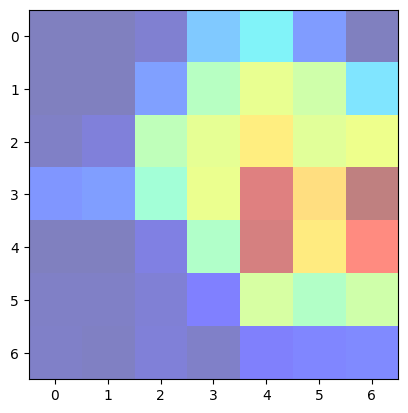

In [10]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights


# Load the image
image_path = 'bird.jpg'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Check if a GPU is available and move the input and model to GPU
device = torch.device('cpu')
model = models.resnet50(weights = ResNet50_Weights.IMAGENET1K_V1)
model = model.to(device)
input_batch = input_batch.to(device)
print("This is the shape of input:", input_batch.shape)



def generate_gradcam(model, input_tensor, target_layer):
    # Register hook to the target layer
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)
    
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])
    
    hook_handles = []
    hook_handles.append(target_layer.register_forward_hook(forward_hook))
    hook_handles.append(target_layer.register_full_backward_hook(backward_hook))

    # Forward pass
    model.eval()
    output = model(input_tensor)

    # Get the index of the class with the highest score
    _, predicted_class = output.max(1)

    # Zero gradients
    model.zero_grad()

    # Backward pass
    output[:, predicted_class].backward()

    # Get hooked activations and gradients
    activations = activations[0].detach()
    gradients = gradients[0].detach()

    # Compute the weight coefficients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight the channels of the activations
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    # Compute the Grad-CAM
    gradcam = torch.mean(activations, dim=1).squeeze()

    # Apply ReLU
    gradcam = F.relu(gradcam)

    # Normalize the Grad-CAM
    gradcam = gradcam - gradcam.min()
    gradcam = gradcam / gradcam.max()
    
    # Remove hooks
    for handle in hook_handles:
        handle.remove()
    
    return gradcam

# Specify the target layer
target_layer = model.layer4[2].conv3  # This may change depending on the architecture
block = model.layer4[2]

# print the architecture of model
# print(model)
print("**************************")
print(target_layer)
print("**************************")
print(block)

# Generate Grad-CAM
gradcam = generate_gradcam(model, input_batch, target_layer)
print(gradcam.shape)
# Visualize the Grad-CAM
plt.imshow(gradcam.cpu(), cmap='jet', alpha=0.5)
plt.axis('on')
plt.show()



[[0.95951656 0.19327376 0.26351115 0.08236055 0.62689737 0.07911348
  0.94882022 0.1014926  0.00262009 0.08316236]
 [0.23138782 0.62438972 0.08062522 0.75188433 0.42504074 0.94537676
  0.29897507 0.35599303 0.64051686 0.13525616]
 [0.90444237 0.05256651 0.61860994 0.54312472 0.07071008 0.96629768
  0.89357251 0.39730931 0.43849018 0.42499534]
 [0.28147068 0.51137108 0.97110375 0.76457509 0.89404678 0.23549352
  0.50867152 0.00756577 0.19676195 0.76717641]
 [0.56946602 0.15894756 0.66024553 0.9239829  0.58243817 0.54782615
  0.01080361 0.96222159 0.85031268 0.23077987]
 [0.64955572 0.94370774 0.60038999 0.28645753 0.58840939 0.4701122
  0.43040258 0.69523582 0.13688974 0.79872093]
 [0.27921767 0.52532063 0.37939519 0.78480115 0.70932656 0.87057289
  0.39110152 0.18908035 0.72067206 0.4441533 ]
 [0.84957803 0.16752054 0.09228551 0.83454904 0.91326057 0.27604445
  0.43354345 0.87864182 0.50839583 0.1454071 ]
 [0.47192969 0.94318301 0.74845394 0.95278029 0.65494371 0.6205994
  0.11514173 0

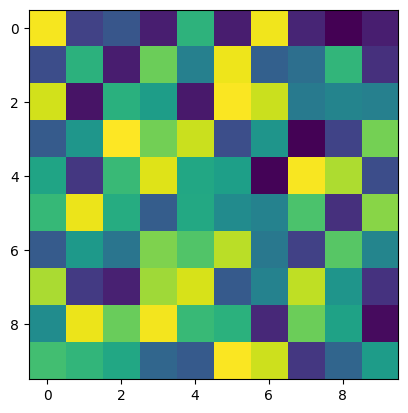

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2D array (for example, an image with random values)
image_data = np.random.rand(10, 10)
print(image_data)
# Display the image
plt.imshow(image_data)
plt.show()


In [3]:
from PIL import Image

# Load the image
image_path = 'golden_retriver.jpg'
image = Image.open(image_path)
print(image)


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x1197 at 0x726A2895B550>


In [1]:
from PIL import Image

# Open an image file
img = Image.open("golden_retriver.jpg")

# Display the image
img.show()

# Get basic information about the image
print(f"Format: {img.format}")  # Output: JPEG, PNG, etc.
print(f"Size: {img.size}")      # Output: (width, height)
print(f"Mode: {img.mode}")      # Output: "RGB", "L" (grayscale), etc.

# # Save the image in a different format
# img.save("path_to_save_image.png")

# Resize the image
img_resized = img.resize((100, 100))
img_resized.show()

# Convert the image to grayscale
img_gray = img.convert("L")
img_gray.show()

Format: JPEG
Size: (1200, 1197)
Mode: RGB


In [9]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights


# Load the image
image_path = 'golden_retriver.jpg'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model
print(input_batch.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example one-dimensional data (e.g., a time series)
data = torch.tensor([[0.1, 0.2, 0.3, 0.4, 0.5]], requires_grad=True)  # 1D input data
target = torch.tensor([1])  # Example target label for classification

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5, 3)
        self.fc2 = nn.Linear(3, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Forward pass
output = model(data)

# Compute loss
loss = criterion(output, target.float())

# Backward pass to compute gradients
loss.backward()

# The gradient of the loss with respect to the input data
saliency = data.grad.data.abs()

print("Input Data: ", data)
print("Saliency Map: ", saliency)


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.